In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import json
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from skimage.io import imread  
import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [67]:
train_dir = '../pidray/train/'
easy_test_dir = '../pidray/easy/'
hard_test_dir = '../pidray/hard/'
hidden_test_dir = '../pidray/hidden/'
train_json = "../pidray/annotations/xray_train.json"
easy_json = "../pidray/annotations/xray_test_easy.json"
hard_json = "../pidray/annotations/xray_test_hard.json"
hidden_json = "../pidray/annotations/xray_test_hidden.json"
train_n = len(os.listdir(train_dir))
easy_n = len(os.listdir(easy_test_dir))
hard_n = len(os.listdir(hard_test_dir))
hidden_n = len(os.listdir(hidden_test_dir))
total_img = train_n + easy_n + hard_n + hidden_n 


```
- pidray (data)
    └── annotations
        ├── xray_test_easy.json
        ├── xray_test_hard.json
        ├── xray_test_hidden.json
        └── xray_train.json
    └── easy
        ├── xray_easy00000.png
        ├── xray_easy00001.png
        └── ...
    └── hard
        ├── xray_hard00000.png
        ├── xray_hard00001.png
        └── ...
    └── hidden
        ├── xray_hidden00000.png
        ├── xray_hidden00001.png
        └── ...
    └── train
        ├── xray_00000.png
        ├── xray_00001.png
        └── ...
```

In [95]:
print(f"The train have {train_n} ({np.round(train_n/total_img, 3)*100 }% of total dataset) ")
print(f"The easy have {easy_n} ({np.round(easy_n/total_img*100, 1)}% of total dataset)")
print(f"The hard have {hard_n} ({np.round(hard_n/total_img, 3)*100 }% of total dataset)")
print(f"The hidden have {hidden_n} ({np.round(hidden_n/total_img, 3)*100 }% of total dataset)")
print(f"Total number of images: {total_img} ")

The train have 29457 (61.8% of total dataset) 
The easy have 9482 (19.9% of total dataset)
The hard have 3733 (7.8% of total dataset)
The hidden have 5005 (10.5% of total dataset)
Total number of images: 47677 


In [5]:
coco = COCO(train_json)


loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


In [6]:
gun_id = coco.getCatIds(['Gun'])
image_id = coco.getImgIds(catIds=gun_id)
print(image_id[0])

21167


In [10]:
anno_id = coco.getAnnIds(imgIds=image_id[0], catIds=gun_id)


1

In [11]:
ann_list = coco.loadAnns(anno_id)
for i in ann_list:
    print(i['bbox'])

[285.49541284403665, 304.58715596330273, 112.8440366972477, 42.20183486238534]


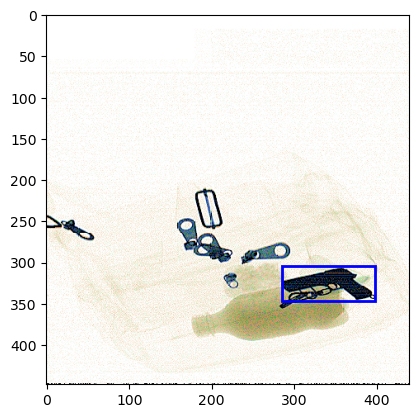

In [17]:
img_id = image_id[0]
img_name = 'xray_'+str(img_id)+".png"
img = Image.open(train_dir+img_name)

fig, ax = plt.subplots()

for i in ann_list:
    box = i['bbox']
    bb = patches.Rectangle(
        (box[0],box[1]),
        box[2],
        box[3],
        linewidth=2,
        edgecolor='blue',
        facecolor='none'
    )
    ax.add_patch(bb)

ax.imshow(img)
plt.show()

In [99]:
f = open(train_json)
anns = json.load(f)
print(anns.keys())
anns['categories']

dict_keys(['info', 'license', 'annotations', 'categories', 'images'])


[{'id': 1, 'name': 'Baton'},
 {'id': 2, 'name': 'Pliers'},
 {'id': 3, 'name': 'Hammer'},
 {'id': 4, 'name': 'Powerbank'},
 {'id': 5, 'name': 'Scissors'},
 {'id': 6, 'name': 'Wrench'},
 {'id': 7, 'name': 'Gun'},
 {'id': 8, 'name': 'Bullet'},
 {'id': 9, 'name': 'Sprayer'},
 {'id': 10, 'name': 'HandCuffs'},
 {'id': 11, 'name': 'Knife'},
 {'id': 12, 'name': 'Lighter'}]

In [36]:
df = pd.DataFrame(anns['annotations'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39708 entries, 0 to 39707
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            39708 non-null  int64  
 1   image_id      39708 non-null  int64  
 2   category_id   39708 non-null  int64  
 3   segmentation  39708 non-null  object 
 4   bbox          39708 non-null  object 
 5   iscrowd       39708 non-null  int64  
 6   area          39708 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 2.1+ MB


In [37]:
def id_to_label(id):
    if id == 1:
        return "Baton"
    elif id == 2:
        return "Pliers"
    elif id == 3:
        return "Hammer"
    elif id == 4:
        return "Powerbank"
    elif id == 5:
        return "Scissors"
    elif id == 6:
        return "Wrench"
    elif id == 7:
        return "Gun"
    elif id == 8:
        return "Bullet"
    elif id == 9:
        return "Sprayer"
    elif id == 10:
        return "HandCuffs"
    elif id == 11:
        return "Knife"
    elif id == 12:
        return "Lighter"


<AxesSubplot: >

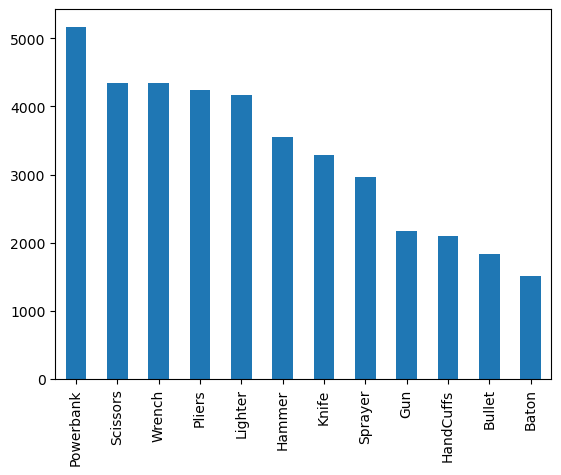

In [119]:
df['label'] = df.category_id.apply(id_to_label)
df['label'].value_counts().plot(kind='bar')

# Preproccessing  

* Yolo require image size multiple of 32

In [132]:
f = open(train_json)
anns = json.load(f)
print(anns.keys())
h_w_df = pd.DataFrame(anns['images'])
h_w_df.drop(['id', 'file_name'], axis=1, inplace=True)
h_w_df.info()

dict_keys(['info', 'license', 'annotations', 'categories', 'images'])
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29457 entries, 0 to 29456
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   height  29457 non-null  int64
 1   width   29457 non-null  int64
dtypes: int64(2)
memory usage: 460.4 KB


In [133]:
print(f"Number of unique width size: {h_w_df['width'].nunique()}")
print(f"Number of unique height size: {h_w_df['height'].nunique()}")
print(f"The two height size are: {h_w_df['height'].unique()}")


Number of unique width size: 387
Number of unique height size: 2
The two height size are: [ 448 1040]


In [144]:
h_w_df.describe()

,height,width
count,29457.000000,29457.000000
mean,483.169909,484.825474
std,139.944018,219.973027
min,448.000000,140.000000
25%,448.000000,360.000000
50%,448.000000,440.000000
75%,448.000000,560.000000
max,1040.000000,3000.000000


<AxesSubplot: >

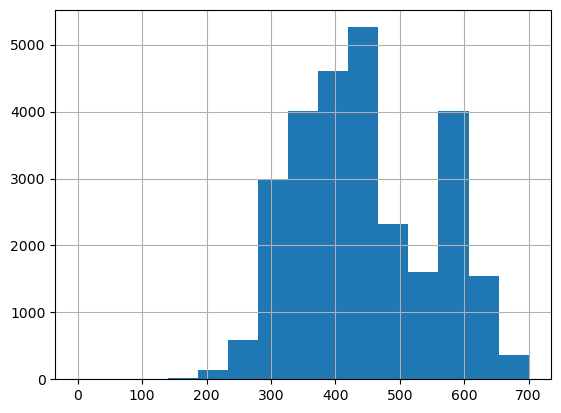

In [152]:
h_w_df['width'].hist(bins=15,range=(0,700))

# Training demo

In [100]:
import ObjecDetectionDataset as ODD

In [101]:
f = open(train_json)
anns = json.load(f)
print(anns.keys())
anns['categories']


dict_keys(['info', 'license', 'annotations', 'categories', 'images'])


[{'id': 1, 'name': 'Baton'},
 {'id': 2, 'name': 'Pliers'},
 {'id': 3, 'name': 'Hammer'},
 {'id': 4, 'name': 'Powerbank'},
 {'id': 5, 'name': 'Scissors'},
 {'id': 6, 'name': 'Wrench'},
 {'id': 7, 'name': 'Gun'},
 {'id': 8, 'name': 'Bullet'},
 {'id': 9, 'name': 'Sprayer'},
 {'id': 10, 'name': 'HandCuffs'},
 {'id': 11, 'name': 'Knife'},
 {'id': 12, 'name': 'Lighter'}]

In [112]:
img_width = 640
img_height = 480
annotation_path = '../pidray/annotations/xray_test_hard.json'
image_dir = '../pidray/hard'
name2idx = {subdict['name']: subdict['id'] for subdict in anns['categories']}
idx2name = {v:k for k, v in name2idx.items()}


In [118]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

class ObjectDetectionDataset(Dataset):
    '''
    Pytorch dataset class to load the image data set, and their corresponding annotation.

    It will return the following:
    ----
    images: torch.Tensor of size(B,C,H,W)
    groundtruth bboxes: torch.Tensor of size(B, max_object, 4)
    groundtruth classes: torch.Tensor of size (B, max_object)
    '''

    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
    
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self,idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
    
    
    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        
        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)
        
        for i, img_path in enumerate(img_paths):
            
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
                
            # read and resize image
            img = io.imread(img_path)
            img = resize(img, self.img_size)
            
            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            
            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])
            
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [ ]:
def parse_annotation(anno_path, img_dir, img_size):
    pass

    